In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')


In [154]:
# Step 2: Load the data
df = pd.read_csv('../data/train.csv')


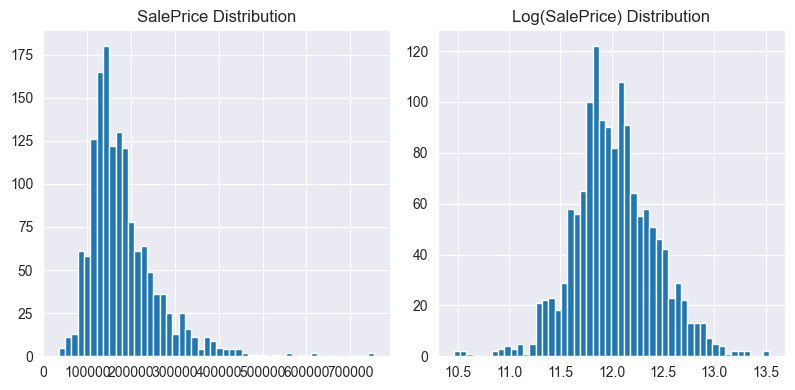

Min: 10.460270761075149, Max: 13.534474352733596, Mean: 12.024057394918406, Std: 0.3994492733225068
Outliers (>3 std): 12


In [155]:
import matplotlib.pyplot as plt

y_temp = df['SalePrice']
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(y_temp, bins=50)
plt.title('SalePrice Distribution')

plt.subplot(1, 3, 2)
plt.hist(np.log1p(y_temp), bins=50)
plt.title('Log(SalePrice) Distribution')

plt.tight_layout()
plt.show()

print(f"Min: {y.min()}, Max: {y.max()}, Mean: {y.mean()}, Std: {y.std()}")
print(f"Outliers (>3 std): {((y - y.mean()).abs() > 3 * y.std()).sum()}")

In [156]:
# Step 3: Data Preprocessing
df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df['OverallScore'] = df['OverallQual'] * df['OverallCond']

features_to_keep = [
    'GrLivArea', 'YearBuilt', 'TotalBath', 'OverallScore', 'OverallQual',
    'Fireplaces', 'KitchenQual', 'GarageArea', '1stFlrSF',  # Added comma here
    '2ndFlrSF'
]

# apply log transformation to SalePrice to reduce skewness, it left-skewed significantly before
y = np.log1p(df['SalePrice'])
X = df[features_to_keep]
X_test_final = df[features_to_keep]

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric columns: {len(numeric_cols)}")  # Fixed indentation
print(f"Categorical columns: {len(categorical_cols)}")  # Fixed indentation

print(f"SalePrice range: ${y.min():,.0f} - ${y.max():,.0f}")
print(f"Mean: ${y.mean():,.0f}, Std: ${y.std():,.0f}")


Numeric columns: 9
Categorical columns: 1
SalePrice range: $10 - $14
Mean: $12, Std: $0


In [157]:
# Step 3.1: Build preprocessing pipeline
# Numeric transformer: impute with mean, remove low variance, then scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical transformer: impute with most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the data
X_encoded = preprocessor.fit_transform(X)
X_test_encoded = preprocessor.transform(X_test_final)

print(f"Features after preprocessing: {X_encoded.shape[1]}")


Features after preprocessing: 12


In [158]:
# Step 4: Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y, test_size=0.4, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)


In [159]:
# Step 5: Define hyperparameters to test
alpha_values = [50, 75, 100, 150, 200]
print(f"\nAlpha values to test: {alpha_values}")



Alpha values to test: [50, 75, 100, 150, 200]


In [160]:
# Step 6: Cross-validation to select best alpha using GridSearchCV
print("\nPerforming 4-fold cross-validation using GridSearchCV...")
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

param_grid = {'alpha': alpha_values}
ridge = Ridge(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=kfold,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    verbose=1
)

grid_search.fit(X_train, y_train)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results['mean_rmse'] = np.sqrt(-cv_results['mean_test_score'])
cv_results['std_rmse'] = np.sqrt(cv_results['std_test_score'])

print("\nCross-Validation Results:")
for idx, row in cv_results.iterrows():
    alpha = row['param_alpha']
    mean_rmse = row['mean_rmse']
    std_rmse = row['std_rmse']
    print(f"Alpha={alpha:>7.3f}: RMSE = {mean_rmse:.2f} (+/- {std_rmse:.2f})")

best_alpha = grid_search.best_params_['alpha']
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"\nBest alpha: {best_alpha}")
print(f"Best CV RMSE: ${best_rmse:,.2f}")



Performing 4-fold cross-validation using GridSearchCV...
Fitting 4 folds for each of 5 candidates, totalling 20 fits

Cross-Validation Results:
Alpha= 50.000: RMSE = 0.17 (+/- 0.12)
Alpha= 75.000: RMSE = 0.17 (+/- 0.11)
Alpha=100.000: RMSE = 0.17 (+/- 0.11)
Alpha=150.000: RMSE = 0.17 (+/- 0.11)
Alpha=200.000: RMSE = 0.17 (+/- 0.11)

Best alpha: 100
Best CV RMSE: $0.17


In [161]:
# Step 7: Use the best model from GridSearchCV
print(f"\nUsing best model from GridSearchCV (alpha={best_alpha})...")
final_model = grid_search.best_estimator_

# Predictions
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nModel Performance:")
print(f"Train RMSE: ${train_rmse:,.2f} | R²: {train_r2:.4f}")
print(f"Val   RMSE: ${val_rmse:,.2f} | R²: {val_r2:.4f}")
print(f"Test  RMSE: ${test_rmse:,.2f} | R²: {test_r2:.4f}")



Using best model from GridSearchCV (alpha=100)...

Model Performance:
Train RMSE: $0.16 | R²: 0.8230
Val   RMSE: $0.17 | R²: 0.8609
Test  RMSE: $0.14 | R²: 0.8669



Generating learning curve...


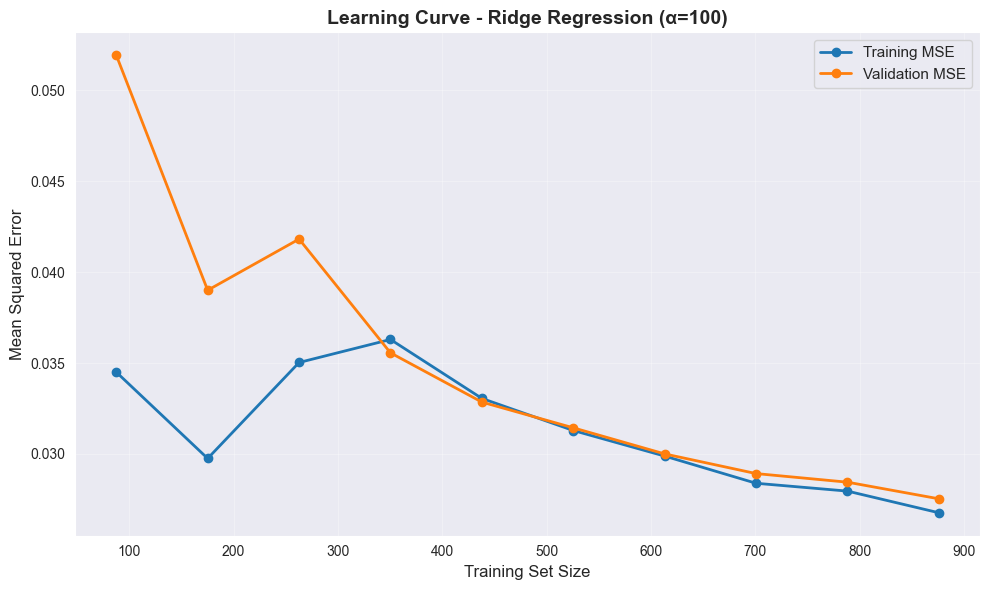

In [162]:
# Step 8: Learning Curve
print("\nGenerating learning curve...")

# Different training set sizes
train_sizes = np.linspace(0.1, 1.0, 10)
train_errors = []
val_errors = []

for size in train_sizes:
    # Sample a subset of training data
    n_samples = int(size * X_train.shape[0])
    X_subset = X_train[:n_samples]
    y_subset = y_train.iloc[:n_samples]

    # Train model
    model = Ridge(alpha=best_alpha, random_state=42)
    model.fit(X_subset, y_subset)

    # Calculate MSE
    y_train_pred_subset = model.predict(X_subset)
    y_val_pred_subset = model.predict(X_val)

    train_mse_subset = mean_squared_error(y_subset, y_train_pred_subset)
    val_mse_subset = mean_squared_error(y_val, y_val_pred_subset)


    train_errors.append(train_mse_subset)
    val_errors.append(val_mse_subset)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes * X_train.shape[0], train_errors, 'o-', label='Training MSE', linewidth=2)
plt.plot(train_sizes * X_train.shape[0], val_errors, 'o-', label='Validation MSE', linewidth=2)
plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.title(f'Learning Curve - Ridge Regression (α={best_alpha})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [163]:
# Step 9: Summary Report
print(f"\nPerformance Metrics:")
print(f"  Training Set   - RMSE: ${train_rmse:,.2f}, R²: {train_r2:.4f}")
print(f"  Validation Set - RMSE: ${val_rmse:,.2f}, R²: {val_r2:.4f}")
print(f"  Test Set       - RMSE: ${test_rmse:,.2f}, R²: {test_r2:.4f}")



Performance Metrics:
  Training Set   - RMSE: $0.16, R²: 0.8230
  Validation Set - RMSE: $0.17, R²: 0.8609
  Test Set       - RMSE: $0.14, R²: 0.8669
